We are going to use ResNeXt image embeddings both to build a scatter plot and to build a model. So we need to add code that will get embeddings for us from the final pooling layer in ResNeXt.

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 179MB/s]


Now we're ready to get the embeddings and thumbnails.

In [2]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)
TRAIN = '/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset'


def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if input_file.endswith('.jpeg') and index < 1000]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 400 rows of orange  in 0:00:55.922459
encoded 396 rows of apple  in 0:00:55.310967
done in 0:01:51.295756


Next we use TSNE to get x/y coordinates from our image embeddings. We're going to use a low value for the perplexity because we want to cluster based on short-distance connections.

In [3]:
import arrow
from sklearn.manifold import TSNE

time_start = arrow.now()
reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='random')
train_df[['x', 'y']] = reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
print('done with TSNE in {}'.format(arrow.now() - time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 796 samples in 0.011s...
[t-SNE] Computed neighbors for 796 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 796 / 796
[t-SNE] Mean sigma: 3.482955
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.057175
[t-SNE] KL divergence after 1000 iterations: 1.169534
done with TSNE in 0:00:03.858533


Now we're ready to plot.

In [4]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: apples vs oranges', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=7, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? We can almost draw a line across our plot separating the apples from the oranges. This suggests we should easily be able to classify our images using these embeddings. Let's build a model.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.4, random_state=2024, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 60 iterations
accuracy: 0.9373
f1: 0.9373
              precision    recall  f1-score   support

       apple       0.92      0.96      0.94       159
      orange       0.95      0.92      0.94       160

    accuracy                           0.94       319
   macro avg       0.94      0.94      0.94       319
weighted avg       0.94      0.94      0.94       319



An f1 of 0.94 isn't bad for almost no effort.

Where are our model's low-confidence predictions? Let's find out.

<Axes: xlabel='x', ylabel='y'>

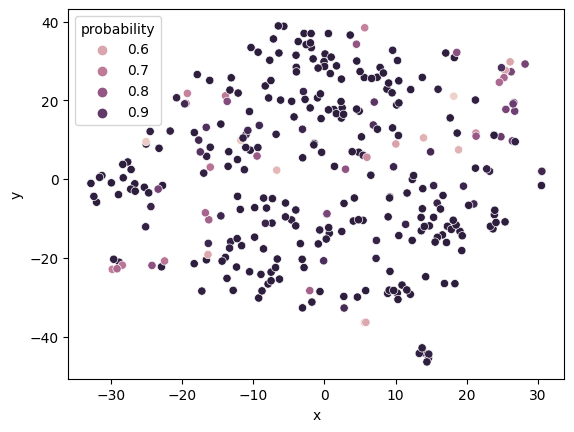

In [6]:
from seaborn import scatterplot

plot_df = train_df.loc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)
scatterplot(data=plot_df, x='x', y='y', hue='probability', )